## 1. Import Library & Load Dataset
* 학습에 필요한 라이브러리를 로드합니다.

In [1]:
!pip install gdown

In [2]:
from scipy import sparse
from tqdm import tqdm

# 계산
import numpy as np

# 전처리
from scipy.special import boxcox1p
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from category_encoders import CountEncoder

# 출력 및 시각화
import pprint
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import seaborn as sns

from IPython.display import display

# 데이터셋 로드 및 정제
import pandas as pd
import gdown

# 코드 셀 실행 후 경고를 무시
import warnings
warnings.filterwarnings(action='ignore')

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 데이터를 로드합니다.
df = pd.read_parquet('./data/train.parquet')

In [4]:
df.head()

,user_id,item_id,user_session,event_time,category_code,brand,price,event_type
0,0b517454-e7c3-44ec-8c39-a68ef9c0ec60,18c11cbb-a18d-4a9e-bdea-6abd3f7d3c04,ad97f19a-f5fb-41ea-a7b2-52c21fb37ab2,2019-11-16 16:31:26 UTC,apparel.shoes,kapika,72.05,view
1,215eeee5-f9c5-4213-8641-7561dbdad1b9,47c5a6da-32d0-4a29-8b51-57304f476ded,6058b45b-bdb9-4d6c-b300-42dcb1cb8280,2019-11-04 18:59:50 UTC,apparel.shoes,respect,82.63,view
2,a25bf14a-49ac-49bb-87de-ee6b300f0cc4,a6d915c6-2bb7-4393-a556-c327723d3666,28a8b8e3-b374-435d-9d5d-b96058ecb75b,2019-11-26 09:01:47 UTC,apparel.tshirt,goodloot,24.43,view
3,09ee8591-25e0-4bb4-ae24-c48ed4212e3c,0fd4da5d-989c-4a75-9ace-2b108f834c8c,f2972db7-9916-4a58-b6f9-c76afde6245e,2019-11-15 16:05:34 UTC,apparel.shoes,baden,70.79,view
4,7acf7c81-69f6-4aa8-b19f-8e85aeaffc28,d52d1c91-5534-4de4-aaf1-318e932e10e7,7d46d970-b40e-4a2f-81a7-65bf23aa0aae,2019-11-16 13:14:09 UTC,apparel.shoes,rooman,53.80,view


In [5]:
# 사용자(user)와 아이템(item)을 인덱스로 매핑하기 위한 딕셔너리 생성
user2idx = {v: k for k, v in enumerate(df['user_id'].unique())}  # 각 사용자를 인덱스로 매핑
idx2user = {k: v for k, v in enumerate(df['user_id'].unique())}  # 각 인덱스를 사용자로 매핑
item2idx = {v: k for k, v in enumerate(df['item_id'].unique())}  # 각 아이템을 인덱스로 매핑
idx2item = {k: v for k, v in enumerate(df['item_id'].unique())}  # 각 인덱스를 아이템으로 매핑

# 사용자와 아이템을 인덱스로 변환하여 새로운 열 추가
df['user_idx'] = df['user_id'].map(user2idx)
df['item_idx'] = df['item_id'].map(item2idx)

In [6]:
df.head()

,user_id,item_id,user_session,event_time,category_code,brand,price,event_type,user_idx,item_idx
0,0b517454-e7c3-44ec-8c39-a68ef9c0ec60,18c11cbb-a18d-4a9e-bdea-6abd3f7d3c04,ad97f19a-f5fb-41ea-a7b2-52c21fb37ab2,2019-11-16 16:31:26 UTC,apparel.shoes,kapika,72.05,view,0,0
1,215eeee5-f9c5-4213-8641-7561dbdad1b9,47c5a6da-32d0-4a29-8b51-57304f476ded,6058b45b-bdb9-4d6c-b300-42dcb1cb8280,2019-11-04 18:59:50 UTC,apparel.shoes,respect,82.63,view,1,1
2,a25bf14a-49ac-49bb-87de-ee6b300f0cc4,a6d915c6-2bb7-4393-a556-c327723d3666,28a8b8e3-b374-435d-9d5d-b96058ecb75b,2019-11-26 09:01:47 UTC,apparel.tshirt,goodloot,24.43,view,2,2
3,09ee8591-25e0-4bb4-ae24-c48ed4212e3c,0fd4da5d-989c-4a75-9ace-2b108f834c8c,f2972db7-9916-4a58-b6f9-c76afde6245e,2019-11-15 16:05:34 UTC,apparel.shoes,baden,70.79,view,3,3
4,7acf7c81-69f6-4aa8-b19f-8e85aeaffc28,d52d1c91-5534-4de4-aaf1-318e932e10e7,7d46d970-b40e-4a2f-81a7-65bf23aa0aae,2019-11-16 13:14:09 UTC,apparel.shoes,rooman,53.80,view,4,4


## 2. EDA

In [7]:
df.head(2)

,user_id,item_id,user_session,event_time,category_code,brand,price,event_type,user_idx,item_idx
0,0b517454-e7c3-44ec-8c39-a68ef9c0ec60,18c11cbb-a18d-4a9e-bdea-6abd3f7d3c04,ad97f19a-f5fb-41ea-a7b2-52c21fb37ab2,2019-11-16 16:31:26 UTC,apparel.shoes,kapika,72.05,view,0,0
1,215eeee5-f9c5-4213-8641-7561dbdad1b9,47c5a6da-32d0-4a29-8b51-57304f476ded,6058b45b-bdb9-4d6c-b300-42dcb1cb8280,2019-11-04 18:59:50 UTC,apparel.shoes,respect,82.63,view,1,1


In [8]:
df.tail(2)

,user_id,item_id,user_session,event_time,category_code,brand,price,event_type,user_idx,item_idx
8350309,4152e35a-c9de-4939-a2b9-eb3f354ed55e,1538c2ae-b7f0-437d-a4e9-9d955cdc07b7,13f82f24-4066-48ae-88f2-0edb246dceef,2020-02-05 10:39:19 UTC,apparel.shoes,respect,89.84,view,597684,25342
8350310,4152e35a-c9de-4939-a2b9-eb3f354ed55e,0dea03f2-ed94-4a32-a7ee-1407a1dc4e69,13f82f24-4066-48ae-88f2-0edb246dceef,2020-02-05 10:39:29 UTC,apparel.shoes,burgerschuhe,79.02,view,597684,1354


In [9]:
display(df.info())
display(df.describe())
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 8350311 entries, 0 to 8350310
Data columns (total 10 columns):
 #   Column         Dtype  
---  ------         -----  
 0   user_id        object 
 1   item_id        object 
 2   user_session   object 
 3   event_time     object 
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   event_type     object 
 8   user_idx       int64  
 9   item_idx       int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 700.8+ MB


None

,price,user_idx,item_idx
count,8.350311e+06,8.350311e+06,8.350311e+06
mean,1.509159e+02,2.410151e+05,9.613204e+03
std,2.292732e+02,1.811589e+05,6.167616e+03
min,7.700000e-01,0.000000e+00,0.000000e+00
25%,4.371000e+01,9.339900e+04,7.727000e+03
50%,7.902000e+01,1.953310e+05,8.763000e+03
75%,1.439400e+02,3.901375e+05,1.215100e+04
max,2.574070e+03,6.382560e+05,2.950100e+04


user_id          0
item_id          0
user_session     0
event_time       0
category_code    0
brand            0
price            0
event_type       0
user_idx         0
item_idx         0
dtype: int64

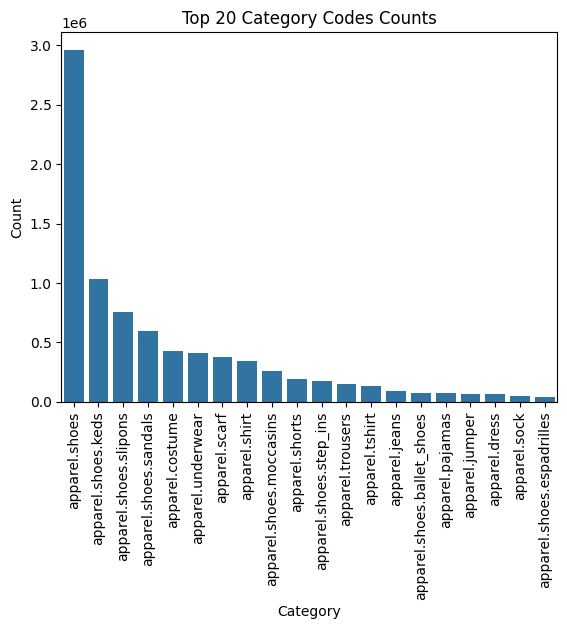

In [10]:
top_category_codes = df['category_code'].value_counts().head(20)

# 새로운 DataFrame 생성
top_category_codes_df = pd.DataFrame({'category_code': top_category_codes.index, 'count': top_category_codes.values})

# Seaborn을 사용한 막대 그래프 그리기
sns.barplot(x='category_code', y='count', data=top_category_codes_df)
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Top 20 Category Codes Counts')
plt.xticks(rotation=90)
plt.show()

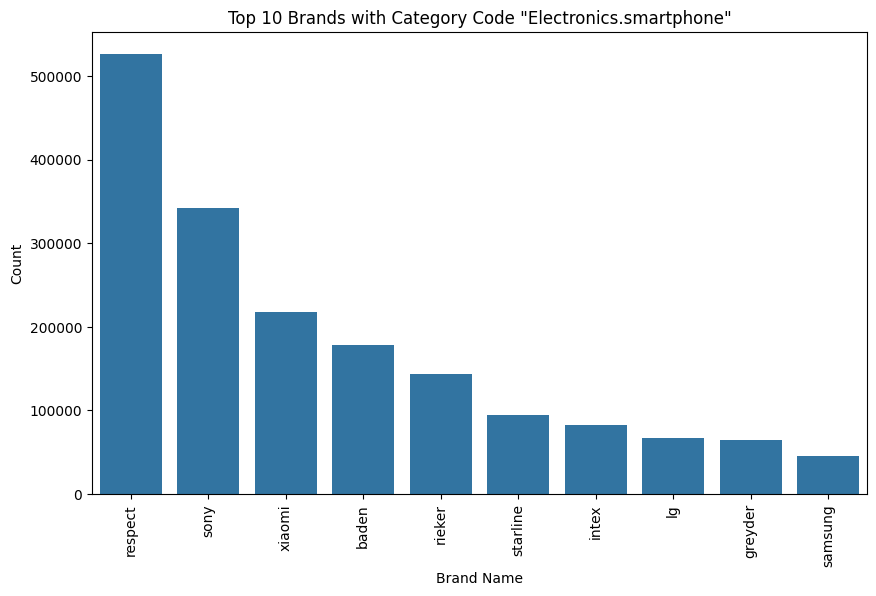

In [11]:
filtered_df = df[df['category_code'].isin(['apparel.shoes'])]

# 필터링된 df에서 category_code 컬럼의 상위 10개 값 추출
top_brands = filtered_df['brand'].value_counts().head(10)

top_brands_df = pd.DataFrame({'brand': top_brands.index, 'count': top_brands.values})

# Seaborn을 사용한 막대 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(x='brand', y='count', data=top_brands_df)
plt.xlabel('Brand Name')
plt.ylabel('Count')
plt.title('Top 10 Brands with Category Code "Electronics.smartphone"')

# x축 레이블 90도 회전
plt.xticks(rotation=90)

plt.show()

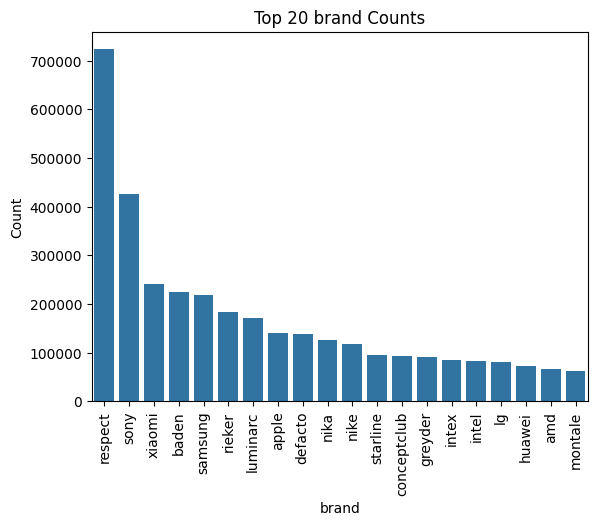

In [12]:
top_brand = df['brand'].value_counts().head(20)

# 새로운 DataFrame 생성
top_brand_df = pd.DataFrame({'brand': top_brand.index, 'count': top_brand.values})

# Seaborn을 사용한 막대 그래프 그리기
sns.barplot(x='brand', y='count', data=top_brand_df)
plt.xlabel('brand')
plt.ylabel('Count')
plt.title('Top 20 brand Counts')
plt.xticks(rotation=90)
plt.show()

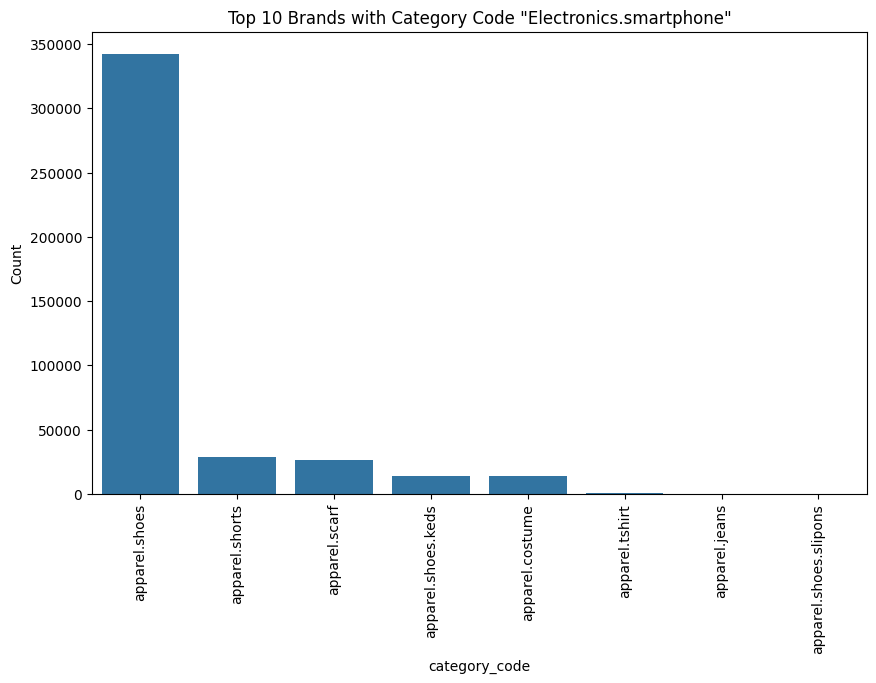

In [54]:
filtered_df = df[df['brand'].isin(['sony'])]

# 필터링된 df에서 category_code 컬럼의 상위 10개 값 추출
top_category_code = filtered_df['category_code'].value_counts().head(10)

top_category_code_df = pd.DataFrame({'category_code': top_category_code.index, 'count': top_category_code.values})

# Seaborn을 사용한 막대 그래프 그리기
plt.figure(figsize=(10, 6))
sns.barplot(x='category_code', y='count', data=top_category_code_df)
plt.xlabel('category_code')
plt.ylabel('Count')
plt.title('Top 10 Brands with Category Code "Electronics.smartphone"')

# x축 레이블 90도 회전
plt.xticks(rotation=90)

plt.show()

In [14]:
#df['date'] = df['event_time'].astype('str').map(lambda x: x[:10])
#df['date']

In [15]:
df['time'] = pd.to_datetime(df['event_time'])
# 년월일만 추출
df['date'] = df['time'].dt.date

df['date']

0          2019-11-16
1          2019-11-04
2          2019-11-26
3          2019-11-15
4          2019-11-16
              ...    
8350306    2020-02-11
8350307    2020-02-05
8350308    2020-02-05
8350309    2020-02-05
8350310    2020-02-05
Name: date, Length: 8350311, dtype: object

In [16]:
# 날짜별 방문자 수
daily_visitors = df['date'].value_counts().sort_index()
daily_visitors

date
2019-11-01    21063
2019-11-02    23706
2019-11-03    22256
2019-11-04    30072
2019-11-05    30855
              ...  
2020-02-25    61576
2020-02-26    63048
2020-02-27     7201
2020-02-28    34244
2020-02-29    39762
Name: count, Length: 121, dtype: int64

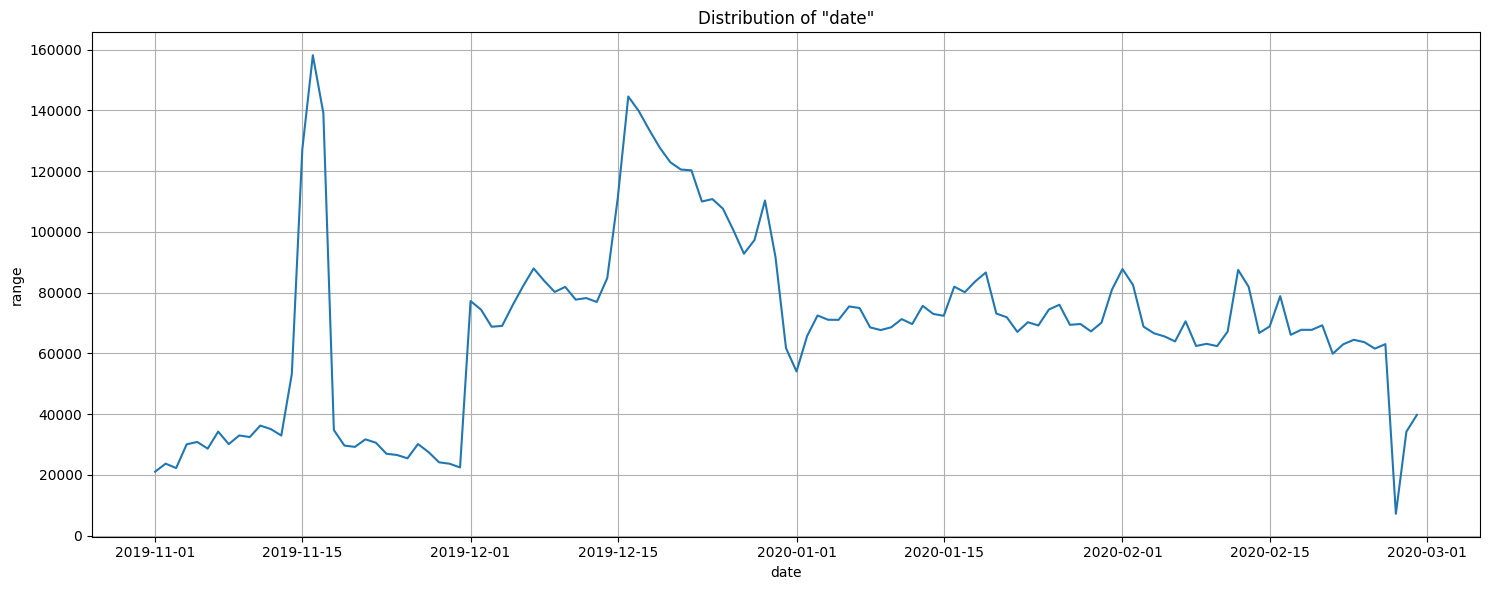

(datetime.date(2019, 11, 1), datetime.date(2020, 2, 29))

In [17]:
min_date = df['date'].min()
max_date = df['date'].max()

plt.figure(figsize=(15, 6))
df['date'].value_counts().sort_index().plot()
plt.title('Distribution of "date"')
plt.xlabel('date')
plt.ylabel('range')
plt.grid(True)
plt.tight_layout()
plt.show()

min_date, max_date

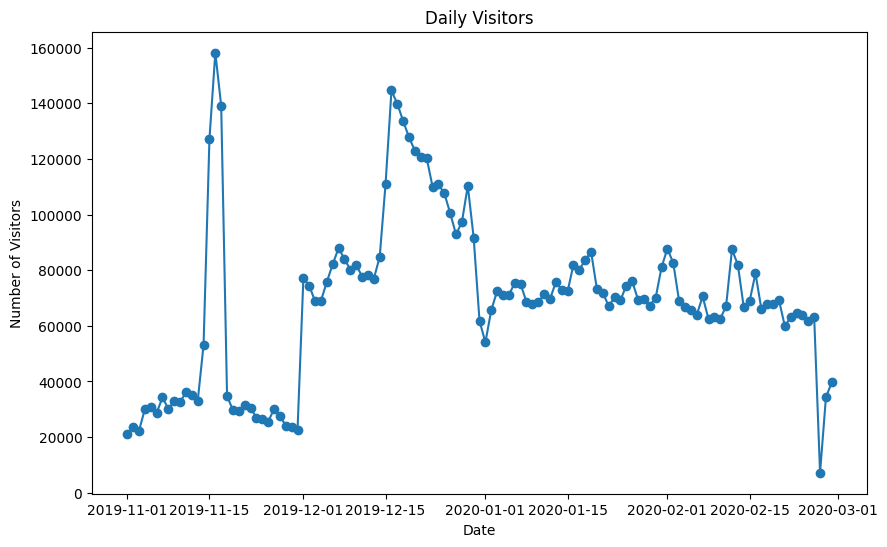

In [18]:
# 날짜별 방문자 수
daily_visitors = df['date'].value_counts().sort_index()

# 그래프
plt.figure(figsize=(10, 6))
daily_visitors.plot(marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.title('Daily Visitors')
plt.show()

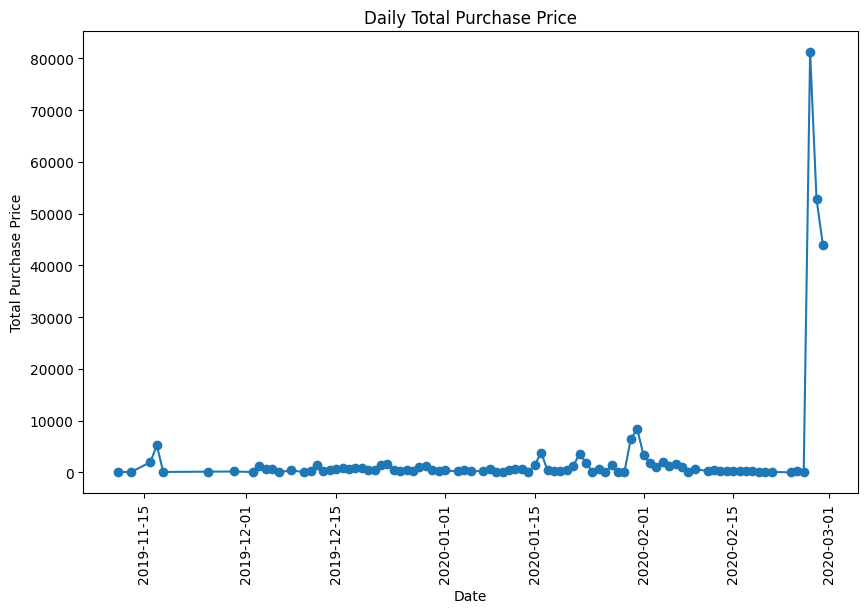

In [19]:
# 'purchase' 행만 필터링하기
purchase_df = df[df['event_type']=='purchase']

# 날짜별 'price' 합
daily_purchase_sum = purchase_df.groupby('date')['price'].sum().reset_index(name='total_purchase_price')

# 선 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(daily_purchase_sum['date'], daily_purchase_sum['total_purchase_price'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Purchase Price')
plt.title('Daily Total Purchase Price')
plt.xticks(rotation=90)
plt.show()

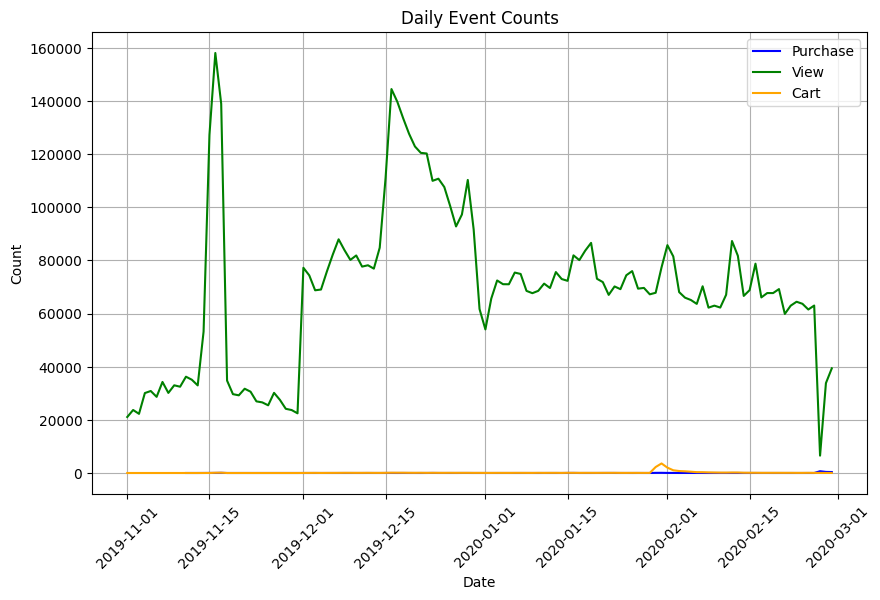

In [20]:
daily_purchase = df[df['event_type'] == 'purchase'].groupby('date').size()
daily_view = df[df['event_type'] == 'view'].groupby('date').size()
daily_cart = df[df['event_type'] == 'cart'].groupby('date').size()

# 그래프 그리기
plt.figure(figsize=(10, 6))
daily_purchase.plot(label='Purchase', color='blue')
daily_view.plot(label='View', color='green')
daily_cart.plot(label='Cart', color='orange')
plt.title('Daily Event Counts')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

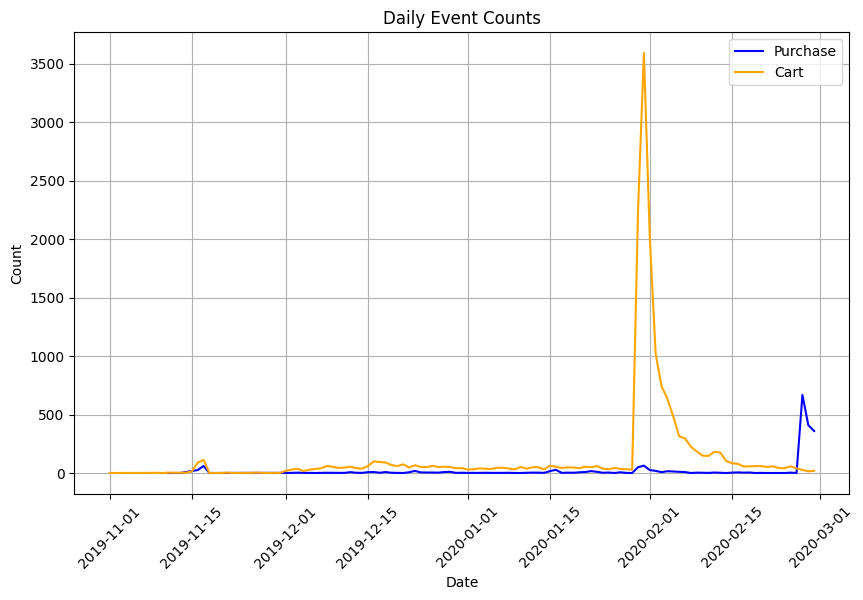

In [21]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
daily_purchase.plot(label='Purchase', color='blue')
daily_cart.plot(label='Cart', color='orange')
plt.title('Daily Event Counts')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

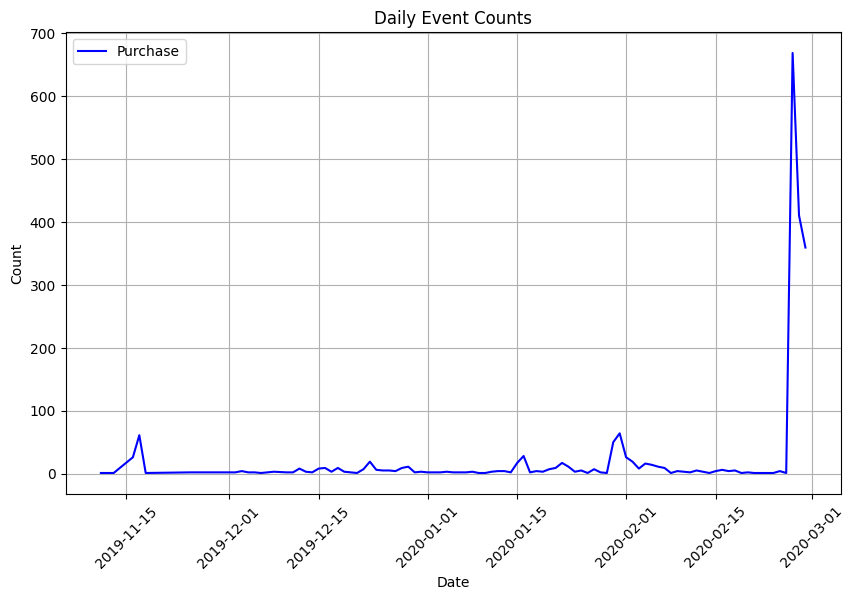

In [22]:
# 그래프 그리기
plt.figure(figsize=(10, 6))
daily_purchase.plot(label='Purchase', color='blue')
plt.title('Daily Event Counts')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [23]:
# customer 중에 지속적으로 purchase를 한 사람들을 알아보자.
purchase_df = df[df['event_type']=='purchase']
# user_id로 그룹화하고 갯수 계산 후 내림차순하기
purchase_counts = purchase_df.groupby('user_id')['event_type'].count().reset_index(name='purchase_count').sort_values(by='purchase_count', ascending=False)
purchase_counts

,user_id,purchase_count
1605,f3f1f11e-7d61-47b9-a3f2-5320873a2b4d,11
245,276be7ef-5b6d-4527-be81-980ab3dfb21e,9
1190,b6925cb4-fce6-4d5c-b6b3-d4a28bd05a1f,9
512,4fc26eb7-19da-4835-bae5-67117076b480,9
1633,f71d96d4-6d63-4da0-b3e1-625b5b5f70ec,8
...,...,...
599,5adb8796-c38a-46bb-963b-18d1e883be91,1
598,5ace34f0-3cb5-4f39-b3ee-7440cdc20ea3,1
597,5a9f26f1-972d-4918-b1ee-73df61d495a0,1
596,5a9641ab-d8b1-4e17-8791-76d569e7b340,1


In [24]:
# customer 중에 지속적으로 purchase를 한 사람들을 알아보자.
view_df = df[df['event_type']=='view']
# user_id로 그룹화하고 갯수 계산 후 내림차순하기
view_counts = view_df.groupby('user_id')['event_type'].count().reset_index(name='view_count').sort_values(by='view_count', ascending=False)
view_counts

,user_id,view_count
240129,6034a8f4-0f6a-4af4-8e8c-7fff6649058b,37207
137021,36da5b84-f57a-413b-8a4d-f8b58a4072c7,16704
213056,5564e159-0959-41a9-af71-f1dc6f4250be,7672
575983,e74fb3bd-3caa-455d-ab95-b3dc9f6ec586,4742
166837,42d49830-b319-42bc-b26e-6d5bc7398600,3274
...,...,...
301974,792b40ed-634f-4889-bd1e-05598ca6a94a,1
551793,dd86c63d-633c-47a6-bf0b-8b09a84a2e29,1
551792,dd86bdb0-4408-4a47-874f-5a291ba8601b,1
301975,792b49e2-09b4-4530-be73-e565aad50ffe,1


In [25]:
display(purchase_counts.describe())
display(view_counts.describe())

,purchase_count
count,1681.000000
mean,1.234979
std,0.776202
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,11.000000


,view_count
count,637440.000000
mean,13.070835
std,58.825797
min,1.000000
25%,2.000000
50%,6.000000
75%,15.000000
max,37207.000000


In [26]:
view_counts[view_counts['view_count']>3000]

,user_id,view_count
240129,6034a8f4-0f6a-4af4-8e8c-7fff6649058b,37207
137021,36da5b84-f57a-413b-8a4d-f8b58a4072c7,16704
213056,5564e159-0959-41a9-af71-f1dc6f4250be,7672
575983,e74fb3bd-3caa-455d-ab95-b3dc9f6ec586,4742
166837,42d49830-b319-42bc-b26e-6d5bc7398600,3274
583911,ea776f22-1f91-44cd-abb3-101a2a9ae33e,3220
60619,183bb447-dfb3-4164-847f-39e3225c229e,3016


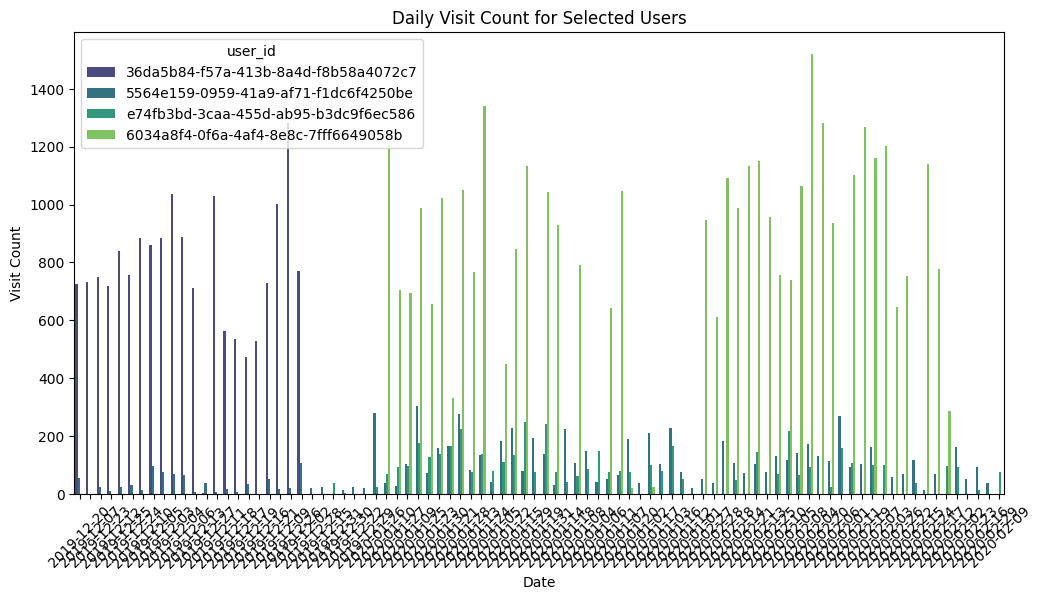

In [27]:
# 특정 user_id들의 방문 날짜 분포
target_user_ids = ['6034a8f4-0f6a-4af4-8e8c-7fff6649058b', '36da5b84-f57a-413b-8a4d-f8b58a4072c7', '5564e159-0959-41a9-af71-f1dc6f4250be', 'e74fb3bd-3caa-455d-ab95-b3dc9f6ec586']

filtered_users_df = df[df['user_id'].isin(target_user_ids)]

# 일별 Count Plot
plt.figure(figsize=(12, 6))
sns.countplot(x='date', hue='user_id', data=filtered_users_df, palette='viridis')
plt.xlabel('Date')
plt.ylabel('Visit Count')
plt.title('Daily Visit Count for Selected Users')
plt.xticks(rotation=45)
plt.show()

In [28]:
# user_id로 그룹화하고 purchase 합 계산
purchase_sum_df = df[df['event_type'] == 'purchase'].groupby('user_id')['price'].sum().reset_index(name='purchase_sum')

# purchase 합 기준으로 내림차순 정렬
sorted_purchase_df = purchase_sum_df.sort_values(by='purchase_sum', ascending=False)

# 결과 출력
sorted_purchase_df

,user_id,purchase_sum
839,7db90cc2-03fc-44d8-a35a-21bbf3df336f,3325.20
512,4fc26eb7-19da-4835-bae5-67117076b480,3281.91
582,58b0ae94-2294-400b-b3d3-46ce6a04b5b2,2470.60
1069,a3baa73e-a69f-47b5-a0a2-f960c1cd8aa6,2203.24
1499,e4a9c7fd-b061-4b33-af4b-27792b8b9a85,2140.67
...,...,...
732,6e8ddedc-de3c-4aec-881d-38237a0a2319,2.25
136,14748f43-1638-4a69-9d50-3b7c141897ce,2.24
455,4725b26b-3f0a-43df-b36b-9ca9bf5e50e6,1.48
298,2f778bfe-7ee3-4fad-8097-085f48e045d1,1.30


In [29]:
sorted_purchase_df.describe()

,purchase_sum
count,1681.000000
mean,151.027228
std,246.600873
min,0.950000
25%,30.820000
50%,71.800000
75%,154.420000
max,3325.200000


In [30]:
df['event_time'] = pd.to_datetime(df['event_time'])

In [31]:
df['event_time']

0         2019-11-16 16:31:26+00:00
1         2019-11-04 18:59:50+00:00
2         2019-11-26 09:01:47+00:00
3         2019-11-15 16:05:34+00:00
4         2019-11-16 13:14:09+00:00
                     ...           
8350306   2020-02-11 08:42:04+00:00
8350307   2020-02-05 10:38:15+00:00
8350308   2020-02-05 10:38:27+00:00
8350309   2020-02-05 10:39:19+00:00
8350310   2020-02-05 10:39:29+00:00
Name: event_time, Length: 8350311, dtype: datetime64[ns, UTC]

In [32]:
# Recency 계산
max_date = df['event_time'].max()
recency_df = df.groupby('user_id')['event_time'].max().reset_index(name='recency')
recency_df['recency'] = (max_date - recency_df['recency']).dt.days

# 다양한 이벤트에 대한 Frequency 계산
event_types = ['purchase', 'cart', 'view']
frequency_df = df[df['event_type'].isin(event_types)].groupby('user_id')['event_type'].count().reset_index(name='frequency')

# Monetary 계산
monetary_df = df[df['event_type'] == 'purchase'].groupby('user_id')['price'].sum().reset_index(name='monetary')

# RFM 데이터 프레임 생성
rfm_df = pd.merge(recency_df, frequency_df, on='user_id')
rfm_df = pd.merge(rfm_df, monetary_df, on='user_id')

rfm_df

,user_id,recency,frequency,monetary
0,002427d7-3da1-4d79-aca9-32f063b179bc,2,21,51.46
1,004c1dc7-7935-4631-9956-2583e99d4dc5,31,57,44.79
2,00b3c728-ca08-4164-be78-292cf2e7aaac,1,16,94.86
3,00ce65c2-8da8-4285-bb03-65b0ce680078,0,6,442.60
4,00e6bd33-fbd7-4090-a11a-22a5679ba9cf,2,29,6.69
...,...,...,...,...
1676,ff327494-84e4-4ebc-b5ed-99483eec882b,5,49,82.63
1677,ff40080d-2797-42a1-baa1-b0e7b71eea5c,2,20,179.89
1678,ff401b30-0939-4890-9937-2d45bf19865d,2,27,22.60
1679,ff5798bc-fa55-448d-8b68-59640b4f0150,1,11,295.90


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Frequency와 Monetary만 사용하여 표준화
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['frequency', 'monetary']])

# K-Means 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42)
rfm_df['cluster'] = kmeans.fit_predict(rfm_scaled)

rfm_df

,user_id,recency,frequency,monetary,cluster
0,002427d7-3da1-4d79-aca9-32f063b179bc,2,21,51.46,2
1,004c1dc7-7935-4631-9956-2583e99d4dc5,31,57,44.79,2
2,00b3c728-ca08-4164-be78-292cf2e7aaac,1,16,94.86,2
3,00ce65c2-8da8-4285-bb03-65b0ce680078,0,6,442.60,0
4,00e6bd33-fbd7-4090-a11a-22a5679ba9cf,2,29,6.69,2
...,...,...,...,...,...
1676,ff327494-84e4-4ebc-b5ed-99483eec882b,5,49,82.63,2
1677,ff40080d-2797-42a1-baa1-b0e7b71eea5c,2,20,179.89,2
1678,ff401b30-0939-4890-9937-2d45bf19865d,2,27,22.60,2
1679,ff5798bc-fa55-448d-8b68-59640b4f0150,1,11,295.90,2


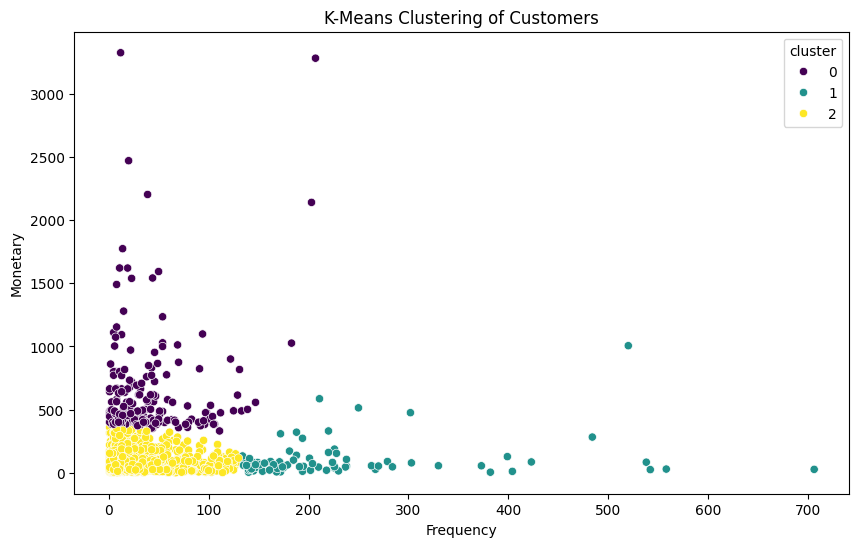

In [34]:
# 클러스터링 결과 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(x='frequency', y='monetary', hue='cluster', data=rfm_df, palette='viridis', legend='full')
plt.title('K-Means Clustering of Customers')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.show()

In [35]:
df['date']

0          2019-11-16
1          2019-11-04
2          2019-11-26
3          2019-11-15
4          2019-11-16
              ...    
8350306    2020-02-11
8350307    2020-02-05
8350308    2020-02-05
8350309    2020-02-05
8350310    2020-02-05
Name: date, Length: 8350311, dtype: object

In [36]:
# 날짜별 방문자 수
daily_visitors = df['date'].value_counts().sort_index()
daily_visitors

date
2019-11-01    21063
2019-11-02    23706
2019-11-03    22256
2019-11-04    30072
2019-11-05    30855
              ...  
2020-02-25    61576
2020-02-26    63048
2020-02-27     7201
2020-02-28    34244
2020-02-29    39762
Name: count, Length: 121, dtype: int64

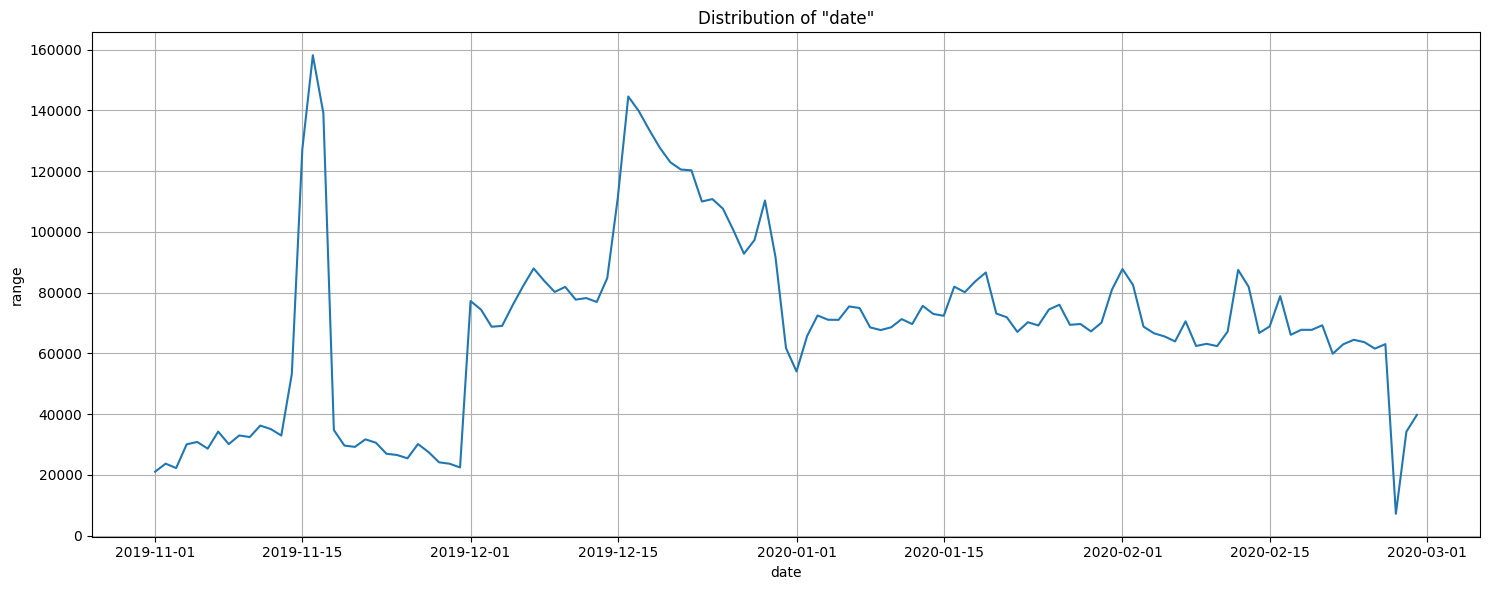

In [37]:
plt.figure(figsize=(15, 6))
df['date'].value_counts().sort_index().plot()
plt.title('Distribution of "date"')
plt.xlabel('date')
plt.ylabel('range')
plt.grid(True)
plt.tight_layout()
plt.show()

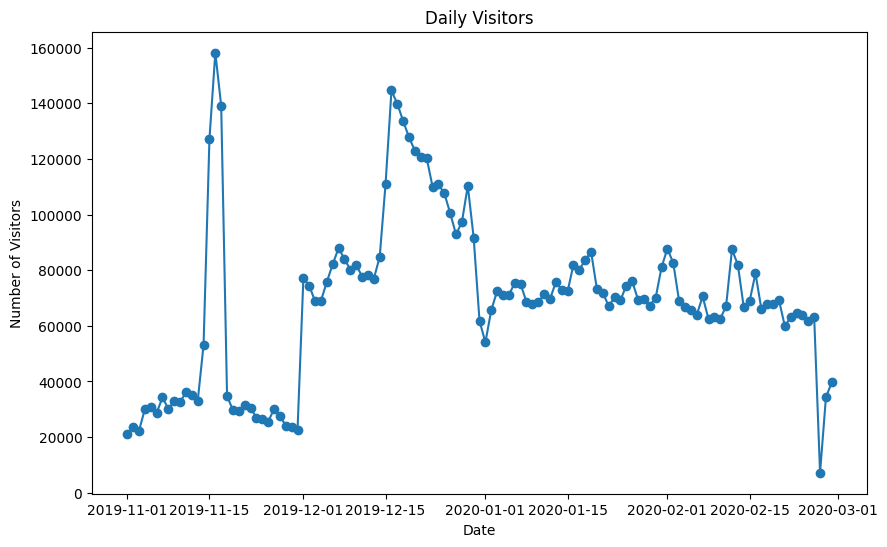

In [38]:
# 그래프
plt.figure(figsize=(10, 6))
daily_visitors.plot(marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Visitors')
plt.title('Daily Visitors')
plt.show()

In [39]:
# about 3 min
df['event_time'] = pd.to_datetime(df['event_time'], format='%Y-%m-%d %H:%M:%S %Z')
df = df.sort_values('event_time', ascending=True)

use_time = df[df['event_type'] == 'purchase']['event_time'].astype('str').map(lambda x: x[10:19])

use_time

1224938     10:45:34
2660        13:40:01
480627      08:51:39
451119      09:03:28
218013      09:04:24
             ...    
7663657     22:15:29
7637729     22:37:59
8075810     22:46:09
8263997     23:41:38
7074888     23:41:41
Name: event_time, Length: 2076, dtype: object

In [40]:
use_time_df = pd.DataFrame(use_time).reset_index()
use_time_df.columns=['id', 'time']

use_time_df['hour'] = use_time_df['time'].str[:3]

use_time_df

,id,time,hour
0,1224938,10:45:34,10
1,2660,13:40:01,13
2,480627,08:51:39,08
3,451119,09:03:28,09
4,218013,09:04:24,09
...,...,...,...
2071,7663657,22:15:29,22
2072,7637729,22:37:59,22
2073,8075810,22:46:09,22
2074,8263997,23:41:38,23


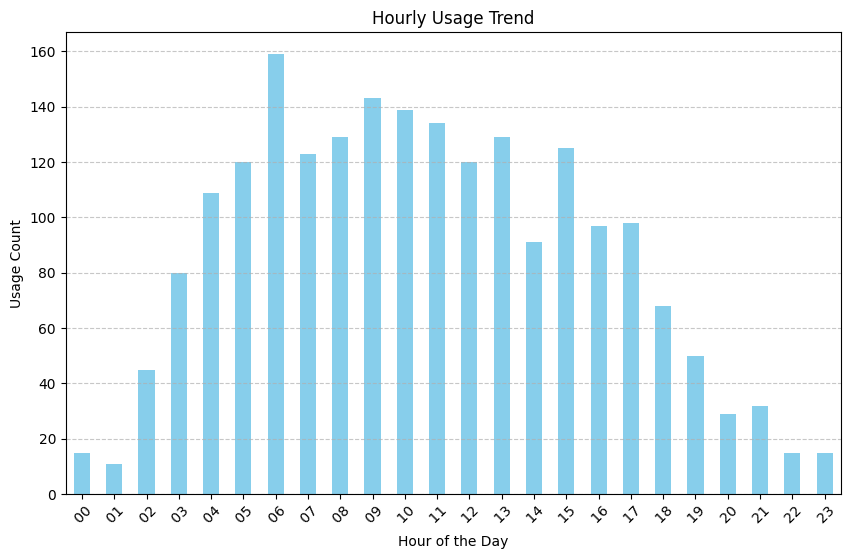

In [41]:
hourly_counts = use_time_df['hour'].value_counts().sort_index()

# 시각화
plt.figure(figsize=(10, 6))
hourly_counts.plot(kind='bar', color='skyblue')
plt.title('Hourly Usage Trend')
plt.xlabel('Hour of the Day')
plt.ylabel('Usage Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [42]:
display(df['brand'].value_counts())
display(df['brand'].value_counts().tail(200))

display(df['event_type'].value_counts())

brand
respect      723404
sony         425834
xiaomi       241872
baden        224849
samsung      217397
              ...  
baobaohao         2
bio-oil           1
azbuka            1
finish            1
nyce              1
Name: count, Length: 1859, dtype: int64

brand
deamia       33
polkaudio    33
secretkey    33
dirran       33
wonderlab    33
             ..
baobaohao     2
bio-oil       1
azbuka        1
finish        1
nyce          1
Name: count, Length: 200, dtype: int64

event_type
view        8331873
cart          16362
purchase       2076
Name: count, dtype: int64

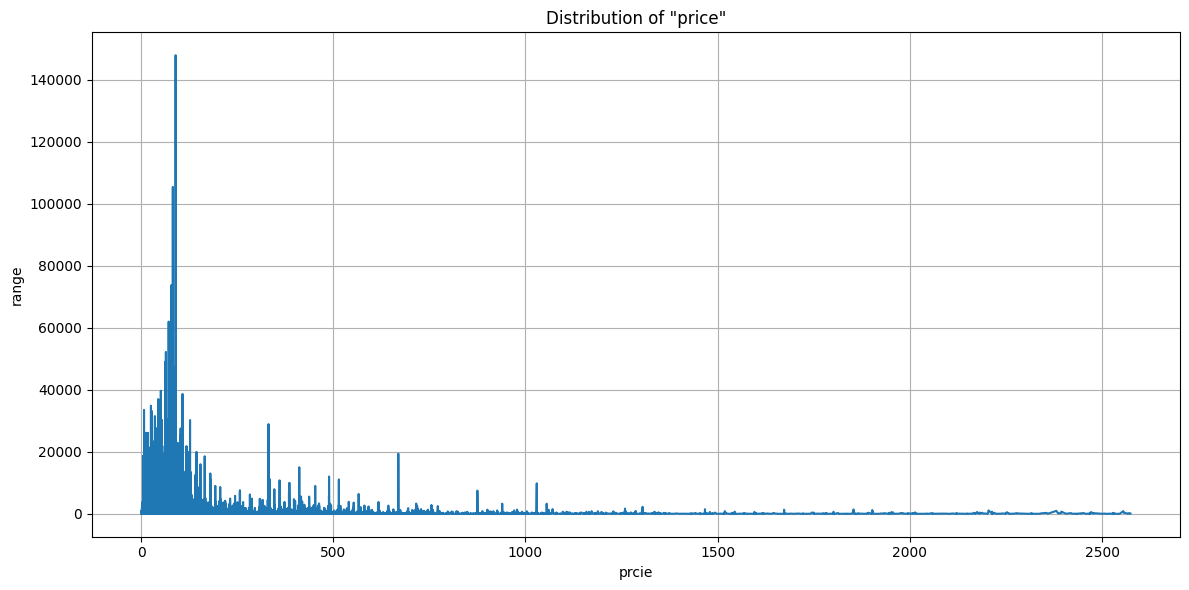

(0.77, 2574.07)

In [43]:
min_price = df['price'].min()
max_price = df['price'].max()

plt.figure(figsize=(12, 6))
df['price'].value_counts().sort_index().plot()
plt.title('Distribution of "price"')
plt.xlabel('prcie')
plt.ylabel('range')
plt.grid(True)
plt.tight_layout()
plt.show()

min_price, max_price

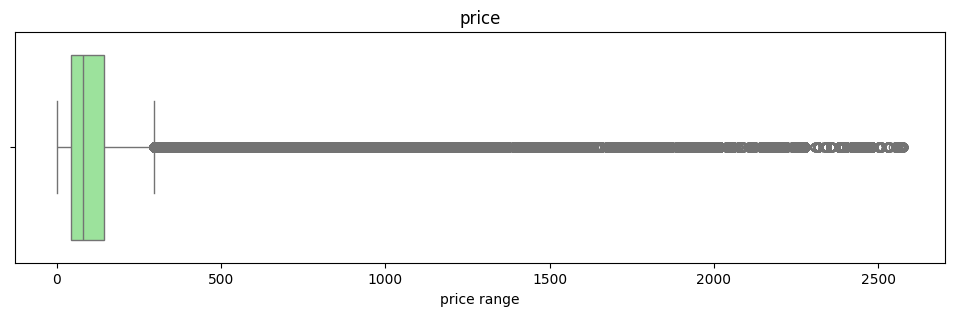

In [44]:
fig = plt.figure(figsize=(12, 3))
sns.boxplot(data = df, x = 'price', color='lightgreen')
plt.title('price')
plt.xlabel('price range')
plt.show()

In [45]:
df['event_time'] = df['event_time'][0:9].map(mpdates.date2num)

In [53]:
df.groupby('category_code')['price'].agg(['min', 'max','mean','quantile'])

,min,max,mean,quantile
category_code,,,,
apparel.belt,10.04,199.46,38.100997,25.74
apparel.costume,1.85,2528.78,183.577953,76.96
apparel.dress,7.70,913.79,66.706324,38.35
apparel.glove,4.71,733.61,52.140353,22.03
apparel.jacket,1.54,764.50,104.564572,77.22
apparel.jeans,2.45,1428.61,80.506033,35.26
apparel.jumper,3.32,2555.28,154.544744,33.21
apparel.pajamas,2.03,2059.24,134.925998,99.10
apparel.scarf,0.77,2056.68,77.053528,25.71
